# **Classificação de Tubercolse através de imagens de Raios-X com EfficientNet**
---
### **Overview of Tuberculosis (TB)**

**De acordo com a [Organização Mundial de Saúde](https://www.who.int/health-topics/tuberculosis#tab=tab_1)**
* A tuberculose é causada por uma bactéria (Mycobacterium tuberculosis) e afeta mais frequentemente os pulmões. A tuberculose é transmitida pelo ar quando pessoas com tuberculose pulmonar tossem, espirram ou cuspem. Uma pessoa precisa inalar apenas alguns germes para ser infectada.
* Se observarmos a radiografia de tórax de uma pessoa com tuberculose avançada, veremos **infecção nos pulmões** e **formação de uma cavidade**.

#### Minha contribuição

Implementei a EfficientNet como arquitetura para classificação no lugar da Densenet121.

---

Este trabalho foi baseado no trabalho de [Sanphat Sangudsup](https://www.kaggle.com/sanphats), [nesta publicação no Kaggle](https://www.kaggle.com/code/sanphats/tuberculosis-classification-densenet121-gradcam/notebook#Model-evaluation), onde foi originalmente aplicado a DenseNet121 como rede neutral.

#### Configuração inicial

Primeiro, carregamos as bibliotecas necessárias e a montagem da partcição do Google Drive, pois, o dataset de imagens foi armazenado no Google Drive pessoal.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# bibliotecas
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import shutil

from keras.preprocessing.image import ImageDataGenerator , load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D , Dense
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score

import glob
import random
import re

import random
from IPython.display import Image
import matplotlib.cm as cm

%matplotlib inline
import warnings
tf.__version__

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'2.14.0'

#### Funções de apoio

Essas funções são usadas no decorrer da execução para auxiliar em tarefas repetitivas como navegar entre diretórios, plotagem de gráficos, e criar a matriz confusão, respectivamente.

O código fonte pode ser acessado [neste repositório no GitHub na pasta de extras/helper_functions.py .](https://github.com/mrdbourke/tensorflow-deep-learning/)

In [3]:
# funções de apoio para execução de tarefas

# verificar diretório por arquivos
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"Existem {len(dirnames)} diretórios e {len(filenames)} itens em '{dirpath}'.")

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes), # create enough axis slots for each class
        yticks=np.arange(n_classes),
        xticklabels=labels, # axes will labeled with class names (if they exist) or ints
        yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

## Preparo do path para os dados

Vamos definir o caminho para as imagens e carregar os caminhos em variáveis.
Após feita a leitura dos caminhos e salvo numa lista de string onde cada item é o caminho para uma imagem, vamos alocar para dataframes, um para cada classe.

É atribuído 1 ao label para identificar as imagens que de Raios-X para pessoas com tuberculose e 0 para Raios-x de pessoas sem tuberculose.

Ao final, cria-se um dataframe com ambas classes e fazemos a leitura da imagem como matriz pela função *lambda* passada para o apply, redimensionamento da matriz imagem para 300x300 e inserida a matriz imagem redimesionada no dataframe na coluna de `mat_images`.

In [4]:
# definindo o caminho das imagens
DATA_PATH="/content/drive//MyDrive/TB_Chest_Radiography_Database"
DATA_TRAIN_NORNAL=DATA_PATH+"/Normal/"
DATA_TRAIN_Tuberculosis=DATA_PATH+"/Tuberculosis/"

# carregar metadados
df_norm = pd.read_excel(DATA_PATH + '/Normal.metadata.xlsx')
df_tb = pd.read_excel(DATA_PATH + '/Tuberculosis.metadata.xlsx')

# mostrar metadados
print('Normal metadata')
print(df_norm.head(2))
print(df_norm.shape[0])
print('_____________________________')
print('TB metadata')
print(df_tb.head(2))
print(df_tb.shape[0])

Normal metadata
  FILE NAME FORMAT     SIZE                                                URL
0  Normal-1    PNG  512*512  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
1  Normal-2    PNG  512*512  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
3500
_____________________________
TB metadata
        FILE NAME FORMAT     SIZE                      URL
0  Tuberculosis-1    PNG  512*512  http://tuberculosis.by/
1  Tuberculosis-2    PNG  512*512  http://tuberculosis.by/
700


In [5]:
ds = DATA_PATH
walk_through_dir(ds)

SOURCE_PATH_NORM = os.path.join(ds, 'Normal')
SOURCE_PATH_TB = os.path.join(ds, 'Tuberculosis')


# os.listdir returns a list containing all files under the given path
print(f"Existem {len(os.listdir(SOURCE_PATH_NORM))} imagens do tipo Normal.")
print(f"Existem {len(os.listdir(SOURCE_PATH_TB))} imagens do tipo Tuberculosis.")

Existem 2 diretórios e 3 itens em '/content/drive//MyDrive/TB_Chest_Radiography_Database'.
Existem 0 diretórios e 3500 itens em '/content/drive//MyDrive/TB_Chest_Radiography_Database/Normal'.
Existem 0 diretórios e 700 itens em '/content/drive//MyDrive/TB_Chest_Radiography_Database/Tuberculosis'.
Existem 3500 imagens do tipo Normal.
Existem 700 imagens do tipo Tuberculosis.


## Pré processamento de dados

Nesta etapa, vamos tratar os dados da seguinte forma:

1. Carregar o caminho das imagens pelo `os.listdir` e adicionar as colunas e imagem e label;
2. Atribuindo o valor 1 para o label das imagens de Raios-X de pessoas com tuberculose e 0 para Raios-X de pessoas sem tuberculose;
3. Concatenar os dataframes de imagens de pessoas com tuberculose e sem tuberculose;
4. Redimensionar as imagens para o tamanho 300x300, recomendado pela arquitetura EfficientNetB0;
5. Embaralhar os dados e resetar o índice;

Em seguida, carregamos um dataframe com o path de cada tipo de imagem de Raios-X e juntamos ele em um só dataframe.

In [ ]:
# Juntar as tabelas de imagens com e sem tuberculose e criar a legenda
df_norm['Tuberculosis'] = float(0)
df_tb['Tuberculosis'] = float(1)
df_norm.drop(columns = ['FORMAT', 'SIZE', 'URL'], inplace = True)
df_tb.drop(columns = ['FORMAT', 'SIZE', 'URL'], inplace = True)
df = pd.concat([df_norm, df_tb])
df = df.sample(frac=1).reset_index(drop=True)

df.rename(columns = {'FILE NAME':'Image'}, inplace = True)
label = ['Tuberculosis']

In [7]:
Normal_img=os.listdir(DATA_TRAIN_NORNAL)
Tuberculosis_img=os.listdir(DATA_TRAIN_Tuberculosis)
dnorm=pd.DataFrame(Normal_img,columns=["images"])
dnorm["labels"]=0
dnorm["images"]=DATA_TRAIN_NORNAL+dnorm["images"]

dtuber=pd.DataFrame(Tuberculosis_img,columns=["images"])
dtuber["labels"]=1
dtuber["images"]=DATA_TRAIN_Tuberculosis+dtuber["images"]


DF2=pd.concat([dnorm,dtuber],ignore_index=True)
DF2["mat_images"]=DF2['images'].apply(lambda x: cv2.resize(cv2.imread(x,0) ,( 300, 300)))
DF2.sample(frac=1, random_state=42).reset_index(drop=True)

,images,labels,mat_images
0,/content/drive//MyDrive/TB_Chest_Radiography_D...,0,"[[0, 0, 14, 200, 204, 210, 211, 152, 78, 36, 1..."
1,/content/drive//MyDrive/TB_Chest_Radiography_D...,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,/content/drive//MyDrive/TB_Chest_Radiography_D...,0,"[[7, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1..."
3,/content/drive//MyDrive/TB_Chest_Radiography_D...,0,"[[76, 60, 54, 49, 48, 48, 49, 50, 50, 51, 52, ..."
4,/content/drive//MyDrive/TB_Chest_Radiography_D...,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...
4195,/content/drive//MyDrive/TB_Chest_Radiography_D...,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4196,/content/drive//MyDrive/TB_Chest_Radiography_D...,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4197,/content/drive//MyDrive/TB_Chest_Radiography_D...,0,"[[15, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8..."
4198,/content/drive//MyDrive/TB_Chest_Radiography_D...,1,"[[197, 195, 193, 191, 190, 188, 188, 186, 183,..."


#### Informações sobre o Dataframe

In [8]:
DF2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   images      4200 non-null   object
 1   labels      4200 non-null   int64 
 2   mat_images  4200 non-null   object
dtypes: int64(1), object(2)
memory usage: 98.6+ KB


## Distribuição por classe

0    3500
1     700
Name: labels, dtype: int64


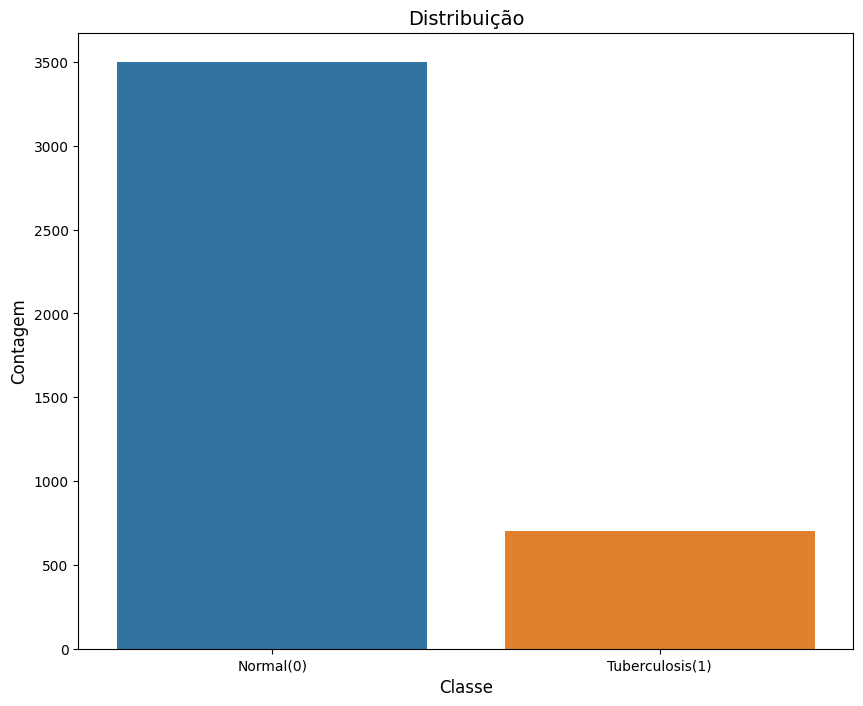

In [10]:
cases_count = DF2['labels'].value_counts()
print(cases_count)

plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Distribuição', fontsize=14)
plt.xlabel('Classe', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Tuberculosis(1)'])
plt.show()

## Preparando para criação de diretórios para as novas imagens que serão geradas

Aqui é definida a função que prepara os diretórios para a divisão das imagens em treino, validação e teste. 

Esse código apenas deve ser executado uma vez! Não executar novamente para não causar erros devido a sobrescritas do diretório já existente.

In [11]:
# função para criar novos diretórios das imagens para treino, validação e teste

def create_img_train_val_test_dirs(root_path):
  train_dir = os.path.join(root_path,'training')
  val_dir = os.path.join(root_path, 'validation')
  test_dir = os.path.join(root_path,'testing')
  os.makedirs(train_dir + '/Normal')
  os.makedirs(train_dir + '/Tuberculosis')
  os.makedirs(val_dir + '/Normal')
  os.makedirs(val_dir + '/Tuberculosis')
  os.makedirs(test_dir + '/Normal')
  os.makedirs(test_dir + '/Tuberculosis')
  os.makedirs(root_path + '/Images')

create_img_train_val_test_dirs('./')



In [12]:
# Mapeando os diretórios de cada tipo
IMAGE_DIR = os.path.join('./', 'Images')

TRAINING_DIR = "./training"
VAL_DIR = "./validation"
TESTING_DIR = "./testing"

TRAINING_NORM_DIR = os.path.join(TRAINING_DIR, "Normal/")
VAL_NORM_DIR = os.path.join(VAL_DIR, "Normal/")
TESTING_NORM_DIR = os.path.join(TESTING_DIR, "Normal/")

TRAINING_TB_DIR = os.path.join(TRAINING_DIR, "Tuberculosis/")
VAL_TB_DIR = os.path.join(VAL_DIR, "Tuberculosis/")
TESTING_TB_DIR = os.path.join(TESTING_DIR, "Tuberculosis/")

### Divisão train, validation e test

Vamos dividir os dados para treino, validação e teste em proporções de treino : 80%, validação : 10%, teste : 10% E ajustar para ter quantias iguais de imagens com e sem tuberculose.

Essa escolha de valores foi feita porquê o autor do [trabalho no qual este foi baseado também utilizou](https://www.kaggle.com/code/sanphats/tuberculosis-classification-densenet121-gradcam/notebook#Partition-as-{train-:-80,-Val-:-10,-Test-:-10}).

Na função a seguir, é verificado se existem arquivos nulos e eles serão ignorados para então serem copiadas as imagens aos diretórios para as imagens de treino, validação e teste.

In [13]:
def split_data(SOURCE, TRAINING, VAL, TESTING, SPLIT_SIZE_TRAIN = 0.8, SPLIT_SIZE_VAL = 0.1):

  zero_dir = [fn for fn in os.listdir(SOURCE) if os.path.getsize(os.path.join(SOURCE, fn)) == 0]
  for fn in zero_dir :
    print(fn,'está vazia, então será ignorado (arquivo nulo).')

  use_dir = [fn for fn in os.listdir(SOURCE) if fn not in zero_dir]
  random.seed(2)
  train_dt = random.sample(use_dir, np.int64(SPLIT_SIZE_TRAIN * len(use_dir)))
  test_dt = [fn for fn in use_dir if fn not in train_dt]
  val_dt = random.sample(test_dt, np.int64(SPLIT_SIZE_VAL * len(use_dir)))
  test_dt = [fn for fn in test_dt if fn not in val_dt]
  for fn in train_dt :
    shutil.copy(os.path.join(SOURCE, fn), TRAINING)
  for fn in val_dt :
    shutil.copy(os.path.join(SOURCE, fn), VAL)
  for fn in test_dt:
    shutil.copy(os.path.join(SOURCE, fn), TESTING)


split_data(SOURCE_PATH_NORM, TRAINING_NORM_DIR, VAL_NORM_DIR,  TESTING_NORM_DIR)
split_data(SOURCE_PATH_TB, TRAINING_TB_DIR, VAL_TB_DIR,  TESTING_TB_DIR)


Na função `images_copy` é feita a cópia das imagens para um diretório único, juntanto os dois tipos de imagens de Raios-X.

In [14]:
def images_copy(SOURCE_N, SOURCE_TB, IMAGE_DIR ):

    zero_dir = [fn for fn in os.listdir(SOURCE_N) if os.path.getsize(os.path.join(SOURCE_N, fn)) == 0]
    zero_dir.append([fn for fn in os.listdir(SOURCE_TB) if os.path.getsize(os.path.join(SOURCE_TB, fn)) == 0])

    for fn in zero_dir :
        print(fn,'está vazia, então será ignorado (arquivo nulo).')

    use_dir_n = [fn for fn in os.listdir(SOURCE_N) if fn not in zero_dir]
    use_dir_tb = [fn for fn in os.listdir(SOURCE_TB) if fn not in zero_dir]
    random.seed(2)

    for fn in use_dir_n :
        shutil.copy(os.path.join(SOURCE_N, fn), IMAGE_DIR)
    for fn in use_dir_tb :
        shutil.copy(os.path.join(SOURCE_TB, fn), IMAGE_DIR)

images_copy(SOURCE_PATH_NORM, SOURCE_PATH_TB, IMAGE_DIR )

[] está vazia, então será ignorado (arquivo nulo).


In [15]:
len(os.listdir(IMAGE_DIR))

4200

Então criamos 2 dataframes diferentes a partir do que foi criado com a junção dos dois tipos de imagens.

A função abaixo cria um dataframe a partir dos diretórios de imagens normais e com tuberculose do dataframe de entrada.

In [16]:
# criar os 3 dataframes para treino, validação e teste
def create_df(NORM_DIR, TB_DIR , df ):
    df_fn_n = os.listdir(NORM_DIR)
    df_fn_tb = os.listdir(TB_DIR)
    df_fn = df_fn_n + df_fn_tb
    df_ext = []
    for fn in df_fn:
        df_ext.append(fn[:-4])
    df_res = df[df['Image'].isin(df_ext)]

    return df_res


train_df = create_df(TRAINING_NORM_DIR, TRAINING_TB_DIR ,df )
val_df = create_df(VAL_NORM_DIR, VAL_TB_DIR, df)
test_df = create_df(TESTING_NORM_DIR, TESTING_TB_DIR, df)

# adicionando ".png" como sufixo no nome do arquivo no DF porque as imagens nas pastas também terminam com .png
train_df.loc[:, 'Image'] = train_df['Image'] + '.png'
val_df.loc[:,'Image'] = val_df['Image'] + '.png'
test_df.loc[:,'Image'] = test_df['Image'] + '.png'

# deve dar 4200 se a distribuição ocorreu corretamente
print(train_df.shape[0] + val_df.shape[0] + test_df.shape[0])

4200


<ipython-input-16-4cbb79c349e2>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'Image'] = train_df['Image'] + '.png'
<ipython-input-16-4cbb79c349e2>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.loc[:,'Image'] = val_df['Image'] + '.png'
<ipython-input-16-4cbb79c349e2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

#### Amostra de imagens do dataset de treino

In [17]:
import glob
train_norm = glob.glob(TRAINING_NORM_DIR +'/*.png')
train_tb = glob.glob(TRAINING_TB_DIR + '/*.png')

train_norm[:5]

['./training/Normal/Normal-1832.png',
 './training/Normal/Normal-831.png',
 './training/Normal/Normal-275.png',
 './training/Normal/Normal-3288.png',
 './training/Normal/Normal-620.png']

#### Raios-X de pacientes saudáveis

Normal


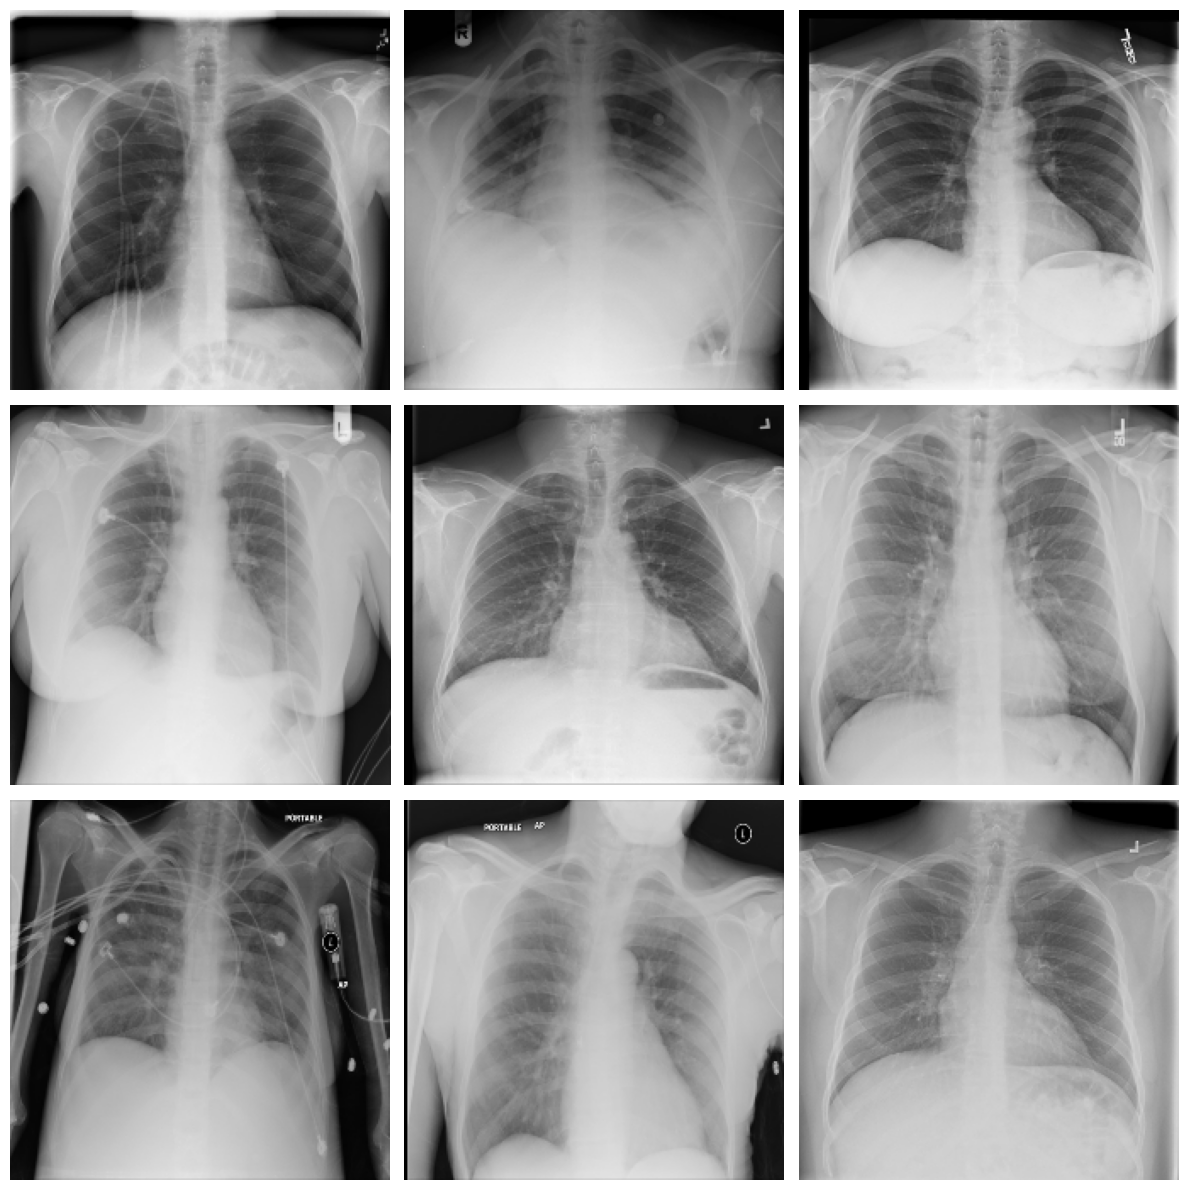

In [18]:
print('Normal')

plt.figure(figsize=(12,12))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_norm[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

#### Raios-X de pacientes com Tuberculose

Tuberculosis


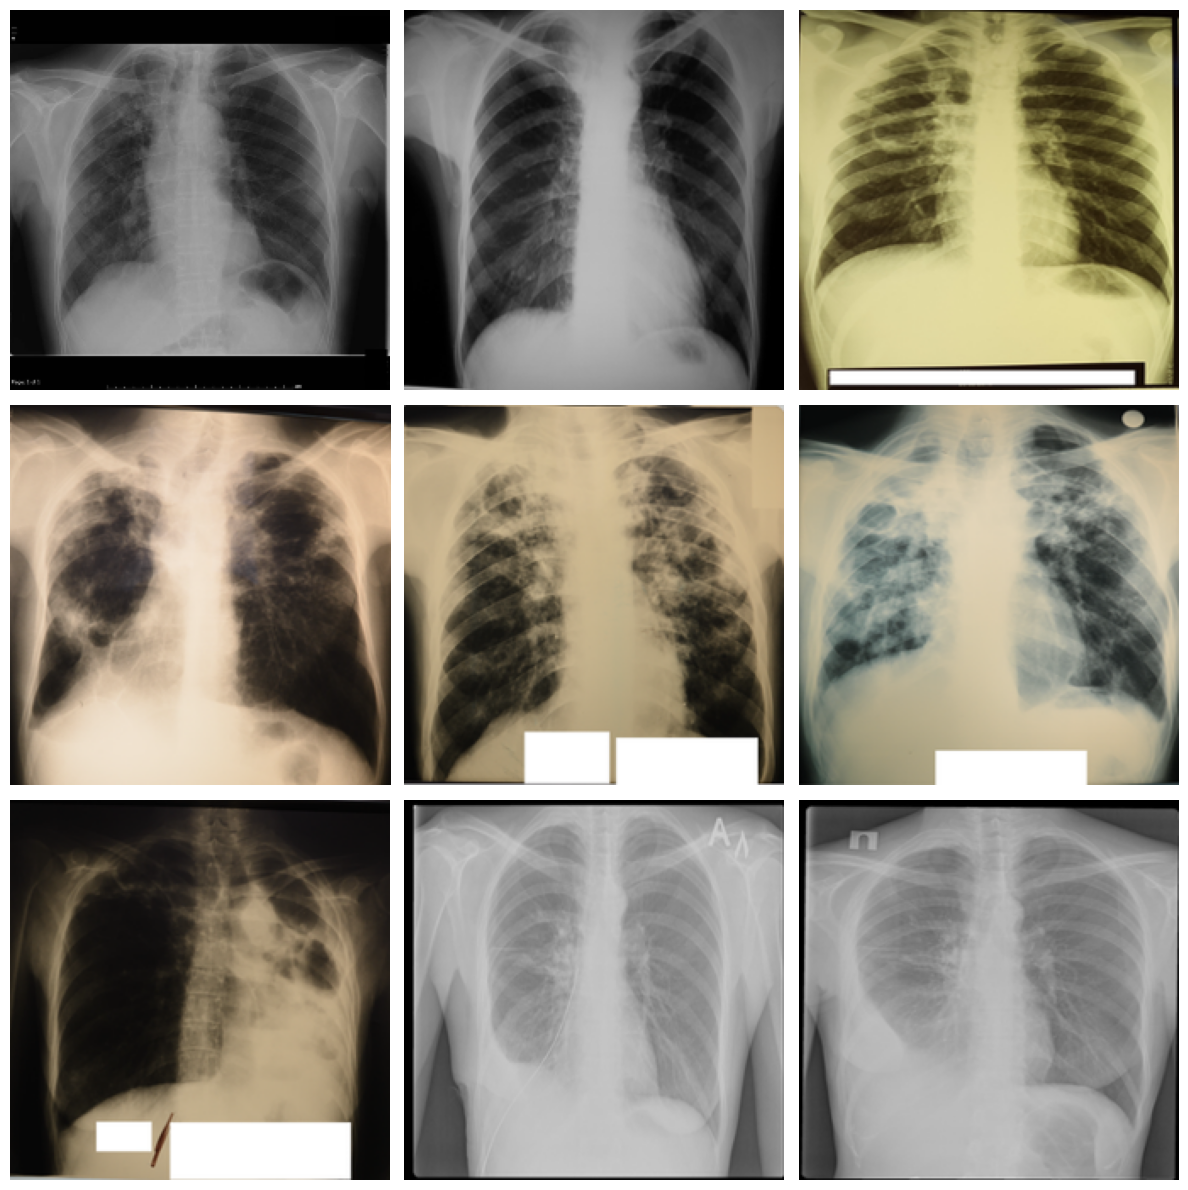

In [19]:


print('Tuberculosis')

plt.figure(figsize=(12,12))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_tb[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()



### Realizando aumento de dados (Data Augmentation)

Para este trabalho, será feita a geração de dados, com base no dataset original, para então ser usado no treino, teste e validação do modelo.

Esse processo é chamado de *data augmentation* e será aplicado usando o [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) do módulo [keras](https://www.tensorflow.org/api_docs/python/tf/keras) do TensorFlow.

Faremos o seguinte:

1. Normalizar a média e desvio padrão das imagens;
2. Embaralhar as imagens após cada época de treino;
3. Definir o tamanho da imagem para 300px por 300px, pois, é a resolução exigida para a [EfficientNetB3](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/);
4. Aplicar alterações na imagem (Rotação, Zoom, Mudanças na altura e largura) baseado em desvio de posição que pode acontecer quando um profissional está realizando o Raio-x no paciente;
5. O gerador converte imagens de Raios-x de canal único (gray-scale) para um formato de três canais através da repetição de valores na imagem em cada canal. (O modelo pré treinado requer três canais de entrada);
6. Ao final, são misturadas as imagens do dataset original com as imagens geradas pelo aumento de dados.



In [20]:
def get_train_generator(df, image_dir, x_col, y_col, shuffle=True, batch_size=8, seed=1, target_w = 300, target_h = 300):
    # x_col (str): nome da coluna no DF que contém os nomes dos arquivos.
    # y_col (list): nome da coluna no DF que contém as legendas.

    print("buscando gerador de treino...")
    # normalizar cada imagem usando estatística de lote
    image_generator = ImageDataGenerator(
        samplewise_center=True, # define cada média amostral como 0
        samplewise_std_normalization= True, # divide cada input por seu desvio padrão
        zoom_range = 0.1,
        rotation_range = 5,
        width_shift_range = 0.1,
        height_shift_range = 0.1)

    # iniciar a partir de um diretório com tamanho especificado de lote
    # e tamanho da imagem de saída
    train_generator = image_generator.flow_from_dataframe( dataframe=df,
                                                           directory=image_dir,
                                                           x_col=x_col,
                                                           y_col=y_col,
                                                           class_mode="raw",
                                                           batch_size=batch_size,
                                                           shuffle=shuffle,
                                                           seed=seed,
                                                           target_size=(target_w,target_h))



    return train_generator


### Construindo um gerador de validação e de teste

Vamos normalizar os dados de validação e de teste usando as **estatísticas calculadas no conjunto de teste**.

Para um menor tempo de execução, vamos apenas tomar uma amostra aleatória do dataset e calcular uma média amostra e desvio padrão amostral, embora o ideal seja calcular usando todo o dataset de treino.

In [21]:
def get_test_and_valid_generator(val_df, test_df, train_df, image_dir, x_col, y_col, sample_size=100, batch_size=8, seed=1, target_w = 300, target_h = 300):

    print("criando geradores de validação e teste...")
    # usar o gerador para amostragem do dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe( dataframe=train_df,
                                                           directory=image_dir,
                                                           x_col= 'Image',
                                                           y_col= 'Tuberculosis',
                                                           class_mode="raw",
                                                           batch_size=sample_size,
                                                           shuffle=True,
                                                           seed=seed,
                                                           target_size=(target_w,target_h))

    # buscar amostra dos dados
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # usar amostra para encaixar média e desvio padrão para o gerador de teste
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)

    # ajustar o gerador para amostragem dos dados de treino
    # isso calcula as estatísticas de dados internos relacionadas às transformações dependentes de dados, com base em uma matriz de dados de amostra
    image_generator.fit(data_sample)
    # caso queira calcular a média e desvio padrão do dataset inteiro
    # image_generator.fit(raw_train_generator)

    # criar gerador de validação e de teste
    val_generator = image_generator.flow_from_dataframe(
            dataframe=val_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    return val_generator, test_generator


In [22]:
train_generator = get_train_generator(train_df, IMAGE_DIR, 'Image', 'Tuberculosis')
val_generator, test_generator= get_test_and_valid_generator(val_df, test_df, train_df, IMAGE_DIR, 'Image', 'Tuberculosis')

buscando gerador de treino...
Found 3360 validated image filenames.
criando geradores de validação e teste...
Found 3360 validated image filenames.
Found 420 validated image filenames.
Found 420 validated image filenames.


## Amostra de imagem gerada

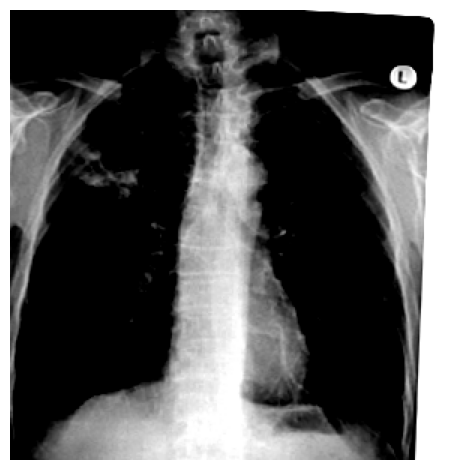

Image shape (300, 300, 3)


In [23]:
base_model_output, y = train_generator.__getitem__(0)
plt.imshow(base_model_output[0])
plt.axis("off")
plt.tight_layout()
plt.show()
print('Image shape',base_model_output[0].shape)

# Tratando o desequilíbrio da quantia de cada classe

Será aplicada a técnica de amostragem com peso em função de perda, pesando as contribuicões de perdas positivas e negativas para tornarem-se iguais.

Uma maneira de fazer isso é multiplicar cada amostra por um fator de peso, wpos e wneg, de modo que a contribuição global de seja a mesma.

Primeiro, calculamos a frequência de cada classe.


In [24]:
train_tb = len(os.listdir(TRAINING_TB_DIR))
train_norm = len(os.listdir(TRAINING_NORM_DIR))
print('Percent of Tuberculosis/Normal : {} %'.format(100 * train_tb/train_norm))

# definindo frequências
freq_pos = round((train_tb/train_norm),2)
freq_neg = 1 - freq_pos



Percent of Tuberculosis/Normal : 20.0 %


Criando contribuições positivas e negativas

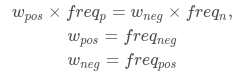

In [25]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

Função de Perda com pesos final

Material complementar

https://www.deeplearningbook.com.br/cross-entropy-cost-function/

https://machinelearningmastery.com/cross-entropy-for-machine-learning/


Screenshot_20231124_153644.png

In [26]:
# criar função de perda com peso
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):

    def weighted_loss(y_true, y_pred):
        # inicializar perda em zero
        loss = 0.0

        # para cada classe, adicionar perda média com pesos para essa classe
        loss += K.mean(-(pos_weights *y_true * K.log(y_pred + epsilon)
                             + neg_weights* (1 - y_true) * K.log( 1 - y_pred + epsilon)))
        return loss

    return weighted_loss



## Criar o modelo com [EfficientNet](https://arxiv.org/abs/1608.06993)

Post sobre [EfficientNet](https://towardsdatascience.com/efficientnetv2-faster-smaller-and-higher-accuracy-than-vision-transformers-98e23587bf04)

Tarefa adicional (incompleta): buscar a matriz de features da EfficientNet para aplicar PCA

Material complementar sobre extração de features:

[How can l load my best model as a feature extractor/evaluator?](https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254)

[https://arxiv.org/abs/1905.11946v5](https://paperswithcode.com/method/efficientnet)

### Observação

Conforme orientado pela documentação e por um log de warning durante a execução, o ideal é utilizar o tipo de *loss* como [`binary_crossentropy`](https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class) para classificação com apenas 2 tipos de classe. Portanto, a função de perda criada foi substituída pela [`binary_crossentropy`](https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class) do próprio Keras.

A adição da camada de *GlobalAveragePooling2D* para [redução de dimensionalidade](https://www.tensorflow.org/tutorials/images/transfer_learning#add_a_classification_head) foi mantida, e também a camada de neurônio único com ativação sigmoidal para a classificação binária.

In [63]:
## criar o modelo base pré-treinado
from tensorflow.keras.applications import EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, classes=2, input_shape=(300, 300, 3))

base_model_output = base_model.output

# adicionar global spatial average pooling layer
base_model_with_GAP2D = GlobalAveragePooling2D()(base_model_output)

# adicionar logistic layer
output = Dense(1, activation="sigmoid")(base_model_with_GAP2D)

model = Model(inputs=base_model.input, outputs = output)
# aqui a função de loss foi substituiída pela binary_crossentropy porque o modelo é binário e foi aconselhado pela documentação do Keras
model.compile(optimizer= 'adam', loss="binary_crossentropy", metrics=["accuracy","AUC"])

In [64]:
# callbacks

checkpoint_path = "./training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

MC = ModelCheckpoint(filepath= checkpoint_path, verbose =2, save_weights_only=True )

### Obersevação 2

Devido a variação muito alta da acurácia na validação, observei quais épocas tinham o melhor desempenho após permitir que o treino fizesse algumas dezenas de execuções e escolhi manualmente a melhor época para interromper o treino, que foi a de número 6.

In [66]:
# fit model
history = model.fit(train_generator,
                              validation_data=val_generator,
                              validation_steps= 30,
                              epochs = 6,
                              callbacks = [MC])

Epoch 1/6
420/420 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9970 - auc: 0.9990
Epoch 1: saving model to ./training_1/cp.ckpt
420/420 [==============================] - 134s 317ms/step - loss: 0.0085 - accuracy: 0.9970 - auc: 0.9990 - val_loss: 5.5751 - val_accuracy: 0.1958 - val_auc: 0.6181
Epoch 2/6
420/420 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 0.9955 - auc: 0.9998
Epoch 2: saving model to ./training_1/cp.ckpt
420/420 [==============================] - 128s 304ms/step - loss: 0.0121 - accuracy: 0.9955 - auc: 0.9998 - val_loss: 2.3505 - val_accuracy: 0.3708 - val_auc: 0.9494
Epoch 3/6
420/420 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.9940 - auc: 0.9983
Epoch 3: saving model to ./training_1/cp.ckpt
420/420 [==============================] - 127s 303ms/step - loss: 0.0226 - accuracy: 0.9940 - auc: 0.9983 - val_loss: 0.7913 - val_accuracy: 0.7417 - val_auc: 0.9963
Epoch 4/6
420/420 [===============

In [67]:
# load weights
model = Model(inputs=base_model.input, outputs = output)
model.load_weights(checkpoint_path)

# Avaliação do modelo

In [68]:
random.seed(a=None, version=2)
set_verbosity(INFO)


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals


# Relatório de classificação

In [69]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))
y_pred = np.where(predicted_vals >= 0.5,1 ,0)
y_pred = y_pred.flatten()

<ipython-input-69-984d31565417>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))


In [70]:
y_test = test_df['Tuberculosis']
print(classification_report(y_test, y_pred))
print("Accuracy of the Model:",accuracy_score(y_test, y_pred)*100,"%")

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97       350
         1.0       0.78      0.99      0.87        70

    accuracy                           0.95       420
   macro avg       0.89      0.97      0.92       420
weighted avg       0.96      0.95      0.95       420

Accuracy of the Model: 95.23809523809523 %


In [71]:
# salvar predições no arquivo csv

y_labels = ['Normal', 'Tuberculosis']
predictions = [y_labels[k] for k in y_pred]

filenames=test_generator.filenames
results=pd.DataFrame({"Image":filenames,
                      "Predictions":predictions})
results.to_csv("predictions.csv",index=False)


# Matriz confusão

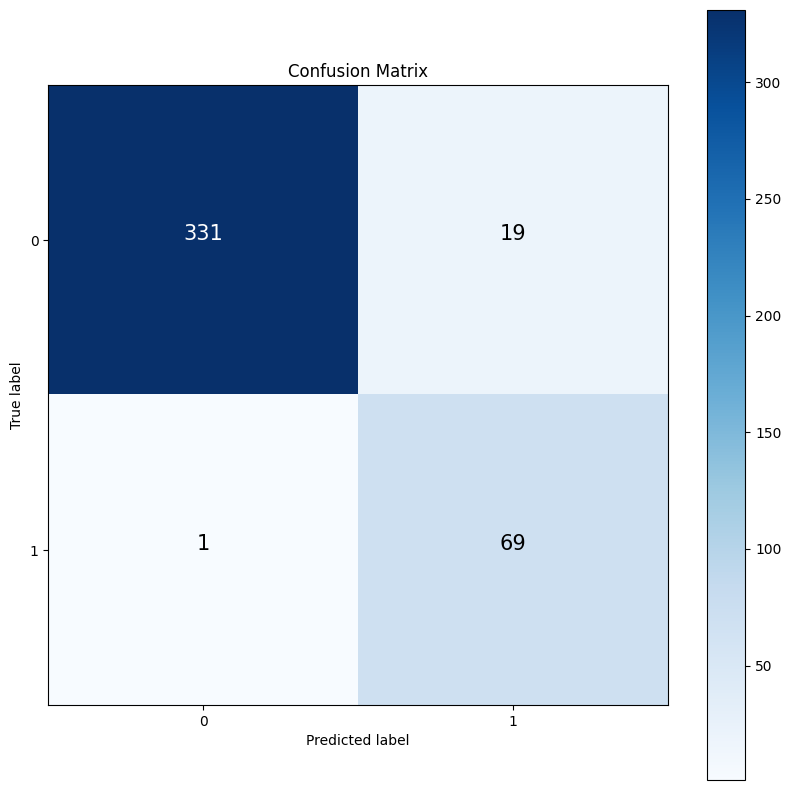

In [72]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

make_confusion_matrix(y_test, y_pred)

## Conclusão

O resultado obtido foi melhor se comparado ao do autor do trabalho original no quesito de detecção para casos positivos de tuberculose, pois, a detecção de Tuberculose teve um aumento significativo, e tendo apenas uma única imagem classificada como Tuberculose falsa negativa. Entretanto, houve aumento de falsos positivos para Tuberculose, subiu de 0 para 19.



# ANEXO A

Reconhecimentos e Direitos Autorais

@autor: Luan Costa Ferro Alves

@data última versão: 19/12/2023

@versão: 1.0

@Agradecimentos: Universidade Federal do Maranhão (UFMA), Professor Doutor Thales Levi Azevedo Valente, e colegas de curso.

@Copyright/License

Este material é resultado de um trabalho acadêmico para a disciplina MINERAÇÃO DE DADOS APLICADA À ENGENHARIA, sobre a orientação do professor Dr. THALES LEVI AZEVEDO VALENTE, semestre letivo 2023.2, curso Engenharia da Computação, na Universidade Federal do Maranhão (UFMA). Todo o material sob esta licença é software livre: pode ser usado para fins acadêmicos e comerciais sem nenhum custo. Não há papelada, nem royalties, nem restrições de "copyleft" do tipo GNU. Ele é licenciado sob os termos da licença MIT reproduzida abaixo e, portanto, é compatível com GPL e também se qualifica como software de código aberto. É de domínio público. Os detalhes legais estão abaixo. O espírito desta licença é que você é livre para usar este material para qualquer finalidade, sem nenhum custo. O único requisito é que, se você usá-los, nos dê crédito.

Copyright © 2023 Educational Material

Este material está licenciado sob a Licença MIT. É permitido o uso, cópia, modificação, e distribuição deste material para qualquer fim, desde que acompanhado deste aviso de direitos autorais.

O MATERIAL É FORNECIDO "COMO ESTÁ", SEM GARANTIA DE QUALQUER TIPO, EXPRESSA OU IMPLÍCITA, INCLUINDO, MAS NÃO SE LIMITANDO ÀS GARANTIAS DE COMERCIALIZAÇÃO, ADEQUAÇÃO A UM DETERMINADO FIM E NÃO VIOLAÇÃO. EM HIPÓTESE ALGUMA OS AUTORES OU DETENTORES DE DIREITOS AUTORAIS SERÃO RESPONSÁVEIS POR QUALQUER RECLAMAÇÃO, DANOS OU OUTRA RESPONSABILIDADE, SEJA EM UMA AÇÃO DE CONTRATO, ATO ILÍCITO OU DE OUTRA FORMA, DECORRENTE DE, OU EM CONEXÃO COM O MATERIAL OU O USO OU OUTRAS NEGOCIAÇÕES NO MATERIAL.

Para mais informações sobre a Licença MIT: https://opensource.org/licenses/MIT.